In [1]:
# bibliotecas
import numpy as np
import scipy as sp
from numpy import pi, sin, cos, exp, sqrt
import pylab as plt
from mpl_toolkits import mplot3d
import scipy.constants as cte
from scipy.constants import hbar, epsilon_0
from scipy.interpolate import interp1d
from scipy.integrate import quad
import timeit

In [2]:
# constantes do problema
deltaEc = 1.25*cte.e # poco do eletron
deltaEv = 1.45*cte.e # poco do buraco
me = cte.m_e*.15
meperp = cte.m_e*0.16
mh = cte.m_e*0.14
mhperp = cte.m_e*0.15
cte_dielet = 4.96 # cte dieletrica
camadas = 1
a = camadas*.59e-9
nome = 'perovskita_' + str(camadas) + '_camadas'

global beta, lamb, V0, m, E
L = 200e-10
mi = 1/(1/meperp + 1/mhperp) # mu_perp
eps = cte_dielet*epsilon_0
N = int(1e3)
h = L/N
xs = np.arange(-L/2, L/2 + h, h)

Primeiro resolvemos
$$
    H_e\psi_e(z_e) = E_e\psi_e(z_e), \qquad  H_h\psi_h(z_h) = E_h\psi_h(z_h)
$$


In [3]:
def V(x):
    if(x < a/2 and x > -a/2):
        return 0
    else:
        return V0

def f(r, x):
    R = r[0]
    S = r[1]
    fR = S
    fS = R*2*m*(V(x)-E)/hbar/hbar
    return np.array([fR, fS], float)

def RK4():
    R = 0.
    S = 1
    r = np.array([R, S], float)
    
    out = []
    for x in xs:
        out.append(r[0])
        k1 = h*f(r, x)
        k2 = h*f(r + .5*k1, x + .5*h)
        k3 = h*f(r + .5*k2, x + .5*h)
        k4 = h*f(r + k3, x + h)
        r += (k1 + 2*k2 + 2*k3 + k4)/6
    
    return out

def solve(Ei):
    R = 0.
    S = 1
    r = np.array([R, S], float)
    
    global E
    E = Ei
    
    for x in xs:
        k1 = h*f(r, x)
        k2 = h*f(r + .5*k1, x + .5*h)
        k3 = h*f(r + .5*k2, x + .5*h)
        k4 = h*f(r + k3, x + h)
        r += (k1 + 2*k2 + 2*k3 + k4)/6
    
    return r[0]

def secante(E1, E2):
    global E
    E = E2
    max_psi = max(np.absolute(np.array(RK4(), float)))
    epsilon = max_psi/1e2
    while abs(solve(E2)) > epsilon:
        E1, E2 = E2, E1 - solve(E1)*(E2 - E1)/(solve(E2) - solve(E1))
        E = E2
        max_psi = max(np.absolute(np.array(RK4(), float)))
        epsilon = max_psi/1e2
    return E2

def raizes(x, y):
    out = []
    for i in range(1, len(y)):
        if (y[i] < 0 and y[i-1] > 0) or (y[i] > 0 and y[i-1] < 0):
            raiz = secante(x[i-1], x[i])
            out.append(raiz)
    return out

def energias(Ei, Ef):
    Erange = np.linspace(Ei, Ef, 100)
    psis = np.array([solve(Ei) for Ei in Erange], float)
    
    Es = raizes(Erange, psis)
    print('Es =', Es)
    
    plt.plot(Erange, psis, '.')
    for i in Es:
        plt.plot(i, 0., 'ro')
    plt.rcParams['figure.figsize'] = 15, 4
    plt.show()
    
    return Es

def binding(Ei, Ef):
    Erange = np.linspace(Ei, Ef, 1000)
    psis = []
    aux = solve(Erange[0])
    for Ei in Erange[1:]:
        psis.append(solve(Ei))
        if ((aux > 0 and psis[-1] < 0) or (aux < 0 and psis[-1] > 0)):
            break
    
    Es = raizes(Erange, psis)
    
    return Es[0]

def psiefunc():
    import timeit
    start = timeit.default_timer()
    
    global V0, m
    V0 = deltaEc
    m = me
    
    Ei = 0
    Ef = 5*cte.e
    E = binding(Ei, Ef)
    print('E =', E)
    
    stop = timeit.default_timer()
    print('Time: ', stop - start)
    
    xs_aux = np.append([-L/2 - 10*h], np.append(xs, [L/2 + 10*h]))
    psis_aux = np.append([0], np.append(RK4(), [0]))
    
    return E, interp1d(xs_aux, psis_aux)

def psihfunc():
    start = timeit.default_timer()
    
    global V0, m
    V0 = deltaEv
    m = mh

    Ei = 0
    Ef = 5*cte.e
    E = binding(Ei, Ef)
    print('E =', E)
    
    stop = timeit.default_timer()
    print('Time: ', stop - start)
    
    xs_aux = np.append([-L/2 - 10*h], np.append(xs, [L/2 + 10*h]))
    psis_aux = np.append([0], np.append(RK4(), [0]))
    
    return E, interp1d(xs_aux, psis_aux)

E = 1.4408080088489633e-19
Time:  15.798116


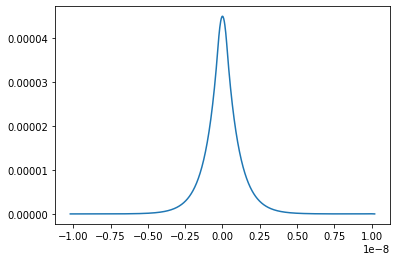

In [4]:
Ee, psie = psiefunc()
xs_aux = np.append([-L/2 - 10*h], np.append(xs, [L/2 + 10*h]))
plt.plot(xs_aux, psie(xs_aux))

E = 1.6365398289425254e-19
Time:  29.6518255


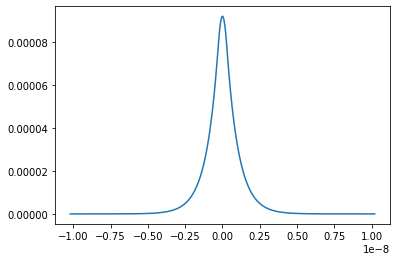

In [5]:
Eh, psih = psihfunc()
xs_aux = np.append([-L/2 - 10*h], np.append(xs, [L/2 + 10*h]))
plt.plot(xs_aux, psih(xs_aux))

$$
    p(a) = \int^{L/2-a}_{-L/2} |\psi_e(z+a)|^2|\psi_h(z)|^2 + |\psi_e(z)|^2|\psi_h(z+a)|^2 dz
$$

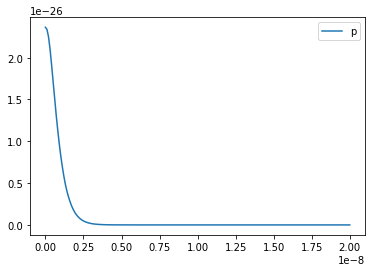

In [6]:
# eh feita uma interpolacao em p(a) para otimizacao
# a = [0, L]
arange = np.linspace(0, L, 200)
# p(a)
p_inte = lambda z, a: (psie(z+a)*psih(z))**2 + (psie(z)*psih(z+a))**2
p = lambda a: quad(p_inte, -L/2, L/2-a, args=(a))[0]
prange = [p(i) for i in arange]
p = interp1d(arange, prange)
plt.plot(arange, p(arange))
plt.legend('p(a)')

$$
    F(a) = 2\pi \left(\frac{\lambda\sqrt{1 - \beta^2}a}{2} + \frac{\lambda^2}{4}\right) \exp\left(-\frac{2\sqrt{1-\beta^2}a}{\lambda}\right)
$$

$$
    G(a) = 2\pi \int^1_0 
    \frac{1-\omega^2}{\omega(1+\omega^2)}
    \left(a\frac{1-\beta^2}{\lambda}\right)^2
    \exp\left[-\frac{\sqrt{1-\beta^2}a}{\lambda}
    \left(\frac{1}{\omega}+\omega\right)\right]d\omega
$$

$$
    J_1 + J_3 = 2\pi
    \left(\frac{\sqrt{1 - \beta^2}a}{2\lambda} - \frac{1}{4}\right) \exp\left(-\frac{2\sqrt{1-\beta^2}a}{\lambda}\right)
$$

$$
    J_2 + J_4 = \pi\int^1_0
    a\sqrt{1-\beta^2}\left(\frac{1}{\omega^2} - 1\right)
    \left[-\frac{4}{\lambda(\omega+1/\omega)^2} - \frac{2a\sqrt{1 - \beta^2}}{(\omega+1/\omega)\lambda^2}\right]
    \exp\left[-\frac{a\sqrt{1-\beta^2}}{\lambda}\left(\omega+\frac{1}{\omega}\right)\right]d\omega
$$

$$
    K(a) = a\pi\beta\int^{\left(1-\sqrt{1-\beta^2}\right)\frac{1}{\beta}}_0
    \left(\frac{1}{\omega^2}-1\right)
    \exp\left[-\frac{a\beta}{\lambda}\left(\frac{1}{\omega}-\omega\right)\right]d\omega
$$

In [7]:
def atualiza():
    global F, G, J, K, beta, lamb
    # F(a)
    F = lambda a: 2*pi*(lamb*sqrt(1 - beta**2)*a/2 + lamb**2/4)*exp(-2*sqrt(1-beta**2)*a/lamb)
    # G(a)
    G_inte = lambda w, a: 2*pi*(1-w**2)/w/(1+w**2)*(a*(1-beta**2)/lamb)**2*exp(-sqrt(1-beta**2)*a/lamb*(1/w+w))
    G = lambda a: quad(G_inte, 0, 1, args=(a))[0]
    # J(a)
    J13 = lambda a: 2*pi*(sqrt(1 - beta**2)*a/2/lamb - 1/4)*exp(-2*sqrt(1-beta**2)*a/lamb)
    J24_inte = lambda w, a: pi*a*sqrt(1-beta**2)*(1/w**2 - 1)*(-4/lamb/(w+1/w)**2 - 2*a*sqrt(1 - beta**2)/(w+1/w)/lamb**2)*\
                exp(-a*sqrt(1-beta**2)/lamb*(w+1/w))
    J24 = lambda a: quad(J24_inte, 0, 1, args=(a))[0]
    J = lambda a: J13(a) + J24(a)
    # K(a)
    arange = np.linspace(0, L, 1000)
    K_inte = lambda w, a: a*pi*beta*(1/w**2-1)*exp(-a*beta/lamb*(1/w-w))
    K = lambda a: quad(K_inte, 0, (1-sqrt(1-beta**2))/beta, args=(a))[0]

$$
    \mathcal{D} = \int^{L}_{0}p(a)F(a)da
$$

$$
    \mathcal{A} = E_e\mathcal{D} + \frac{\hbar^2}{2m^*_e}\int^{L}_0 p(a)G(a)da
$$

$$
    \mathcal{B} = E_h\mathcal{D} + \frac{\hbar^2}{2m^*_h}\int^{L}_0 p(a)G(a)da
$$

$$
    \mathcal{C} = \mathcal{C_T} + \mathcal{C_V} = -\frac{\hbar^2}{2\mu_\perp} \int^{L}_0 p(a)J(a)da - \frac{e^2}{4\pi\epsilon} \int^{L}_0 p(a)K(a)da
$$

In [9]:
def Eb():
    atualiza()
    D_inte = lambda a: p(a)*F(a)
    D = quad(D_inte, 0, L)[0]
    A_inte = lambda a: p(a)*G(a)
    aux = quad(A_inte, 0, L)[0]
    A = Ee*D + hbar**2/2/me*aux
    B = Eh*D + hbar**2/2/mh*aux
    C1_inte = lambda a: p(a)*J(a)
    C2_inte = lambda a: p(a)*K(a)
    CT = -hbar**2/2/mi*quad(C1_inte, 0, L)[0]
    CV = -cte.e**2/4/pi/eps*quad(C2_inte, 0, L)[0]
    C = CT + CV
    
    return (A + B + C)/D

def final():
    global beta, lamb
    betaini = .6
    betafin = 1
    beta_range = np.linspace(betaini, betafin, 100)
    lambini = 2.4
    lambfin = 3.25
    lamb_range = np.linspace(lambini*1e-9, lambfin*1e-9, 100)
    X, Y = np.meshgrid(lamb_range, beta_range)
    
    Z = []
    for betai in beta_range:
        beta = betai
        Es_aux = []
        for lambi in lamb_range:
            lamb = lambi
            Es_aux.append(Eb() - Eh - Ee)
        Z.append(Es_aux)
    Z = np.array(Z)
    
    # acha o minimo e seus parametros
    energia = np.amin(Z)/cte.e*1e3
    beta = beta_range[np.where(Z == np.amin(Z))[0][0]]
    lamb = lamb_range[np.where(Z == np.amin(Z))[1][0]]/1e-9
    
    # grafico
    fig, ax = plt.subplots(1)
    im = ax.imshow(Z/1e-3/cte.e, origin='lower', extent=[lambini, lambfin, betaini, betafin], aspect='auto')
    plt.xlabel(r'$\lambda$' + ' (nm)')
    plt.ylabel(r'$\beta$')
    cb = plt.colorbar(im)
    cb.set_label(r'$E_B$' + ' (meV)')
    plt.title(r'$E_B = $' + str(round(energia, 2)) + ' (meV), ' +\
            r'$\lambda = $' + str(round(lamb, 2)) + ' (nm), ' +\
            r'$\beta = $' + str(round(beta, 2)))
    plt.plot(lamb, beta, color='red', marker='.')
    plt.savefig(nome + 'B.svg')
    plt.show()

beta: 0.6
beta: 0.604040404040404
beta: 0.6080808080808081
beta: 0.6121212121212121
beta: 0.6161616161616161
beta: 0.6202020202020202
beta: 0.6242424242424243
beta: 0.6282828282828282
beta: 0.6323232323232323
beta: 0.6363636363636364
beta: 0.6404040404040404
beta: 0.6444444444444444
beta: 0.6484848484848484
beta: 0.6525252525252525
beta: 0.6565656565656566
beta: 0.6606060606060606
beta: 0.6646464646464646
beta: 0.6686868686868687
beta: 0.6727272727272727
beta: 0.6767676767676767
beta: 0.6808080808080808
beta: 0.6848484848484848
beta: 0.6888888888888889
beta: 0.692929292929293
beta: 0.6969696969696969
beta: 0.701010101010101
beta: 0.705050505050505
beta: 0.7090909090909091
beta: 0.7131313131313131
beta: 0.7171717171717171
beta: 0.7212121212121212
beta: 0.7252525252525253
beta: 0.7292929292929293
beta: 0.7333333333333333
beta: 0.7373737373737373
beta: 0.7414141414141414
beta: 0.7454545454545454
beta: 0.7494949494949494
beta: 0.7535353535353535
beta: 0.7575757575757576
beta: 0.76161616161

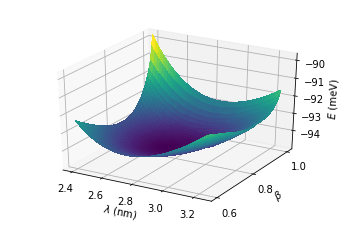

<Figure size 432x288 with 0 Axes>

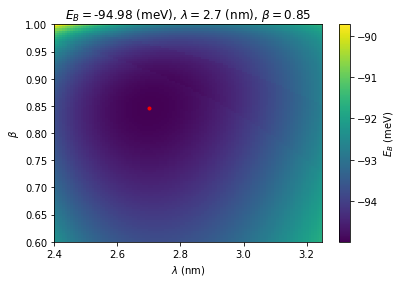

Time:  26.429734191666647  minutos


In [343]:
final()